In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import csv
import datetime

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #ez hogy a rákban nem a defaultja a jupyternek?

# saját függvényeink
from functions import *

In [49]:
bipartite_data = createNxGraph()
projected_graph = listMEPs()
mep_social_network = nx.algorithms.bipartite.projected_graph(bipartite_data, projected_graph)


Szóval, van egy 754 csúcsú gráfunk a social networkről, most már minden csúcs az MEP-k NEVÉVEL van címkézve. Így egy kicsit át kell írogatni valszeg algoritmusokat, de alapvetően mostly ugyanaz marad a buli.

Két fő gráfunk van: az `mep_social_network` a fontosabb: ebben az MEP-k vannak, és az élek a co-sponsorship. A `myGraph` pedig az eredeti páros gráf, amiben az egyik oldal az MEP-k, a másik oldal az amendmentek, és az él azt jelenti hogy az adott MEP sikeresen kontribuált az adott amendmenthez.

TODO: kéne csinálni olyan gráfokat is, amik az időbeli változását tudják mutatni a dolognak.

In [12]:
deg_hist = nx.degree_histogram(bipartite_data)
deg_hist

[0,
 134299,
 32769,
 20866,
 16829,
 13583,
 9798,
 8115,
 5789,
 4525,
 3260,
 2349,
 1982,
 1370,
 780,
 829,
 461,
 359,
 182,
 130,
 85,
 52,
 71,
 55,
 84,
 5,
 4,
 0,
 7,
 1,
 0,
 1,
 0,
 2,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 1

In [13]:
degs = dict(bipartite_data.degree())

sorted_nodes = sorted(degs.items(), key=lambda x: x[1], reverse=True)
sorted_nodes[:10]

[('Olivier CHASTEL', 5155),
 ('Lina GÁLVEZ MUÑOZ', 4483),
 ('Marc ANGEL', 4350),
 ('Maria-Manuel LEITÃO-MARQUES', 4245),
 ('Maria GRAPINI', 4200),
 ('Nicolae ŞTEFĂNUȚĂ', 3914),
 ('Milan BRGLEZ', 3650),
 ('Ramona STRUGARIU', 3544),
 ('Manuel PIZARRO', 3533),
 ('Dragoș PÎSLARU', 3491)]

Akkor I guess ezek a legaktívabb EP képviselők. Jár nekik a keksz.

Itt megnézzük hogy ők kik és miért.

In [14]:
for i in sorted_nodes[:10]:
    print(getMEPData("MEPName", i[0]))

{'OfficialMEPID': '197463', 'MEPName': 'Olivier CHASTEL', 'MemberState': 'Belgium', 'EPGroup': 'RE', 'NationalParty': 'Reformist Movement'}
{'OfficialMEPID': '197702', 'MEPName': 'Lina GÁLVEZ MUÑOZ', 'MemberState': 'Spain', 'EPGroup': 'S&D', 'NationalParty': "Spanish Socialist Workers' Party"}
{'OfficialMEPID': '202073', 'MEPName': 'Marc ANGEL', 'MemberState': 'Luxembourg', 'EPGroup': 'S&D', 'NationalParty': "Luxembourg Socialist Worker's Party"}
{'OfficialMEPID': '197635', 'MEPName': 'Maria-Manuel LEITÃO-MARQUES', 'MemberState': 'Portugal', 'EPGroup': 'S&D', 'NationalParty': 'Socialist Party'}
{'OfficialMEPID': '124785', 'MEPName': 'Maria GRAPINI', 'MemberState': 'Romania', 'EPGroup': 'S&D', 'NationalParty': 'Social Democratic Party'}
{'OfficialMEPID': '58766', 'MEPName': 'Nicolae ŞTEFĂNUȚĂ', 'MemberState': 'Romania', 'EPGroup': 'RE', 'NationalParty': 'Save Romania Party'}
{'OfficialMEPID': '197446', 'MEPName': 'Milan BRGLEZ', 'MemberState': 'Slovenia', 'EPGroup': 'S&D', 'NationalPart

Ami talán érezhető ezekből az adatokból, hogy a top 10 aktív MEP-nek a csoportja mind RE vagy S&D. A tagállamok közül Románia képviselteti magát nagyon erősen.

A következő fokszám gyakoriság ábrán csak a 0 és 20 kozotti ertekek látszodnak rendesen (bár amik nem egy számjegyű a gyakoriságuk azon fokszámok kb 1 és 25 közt vannak)

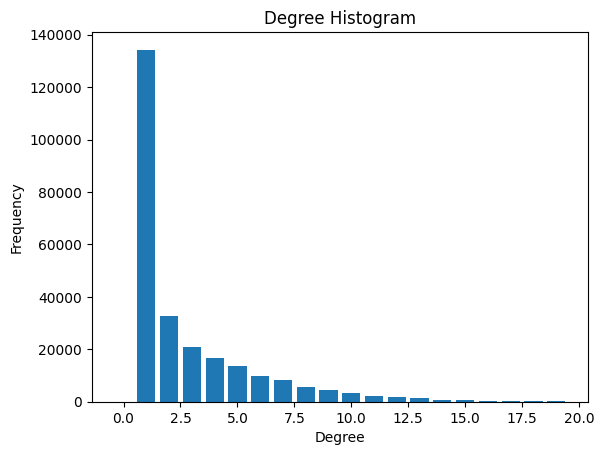

In [15]:
plt.bar(list(x for x in range(len(deg_hist[:20]))), deg_hist[:20], align='center')
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

Esetleg latvanyosabb ha azt mondjuk hogy kizárjuk az 1 fokszámot, merthogy az csak 1 ember javaslata/ 1 db javaslat (A többi 25 - nél nagyobb fokszám pedig nagyjából mind 0,1,2,3 gyakoriságú)

^- Ez nem igazán így van. A degree-k itt azt jelentik, hogy egy adott MEP hány emberrel kollaborált.

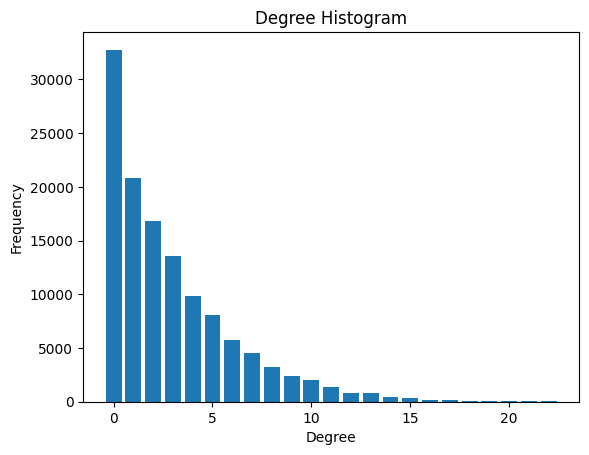

In [16]:
plt.bar(list(x for x in range(len(deg_hist[2:25]))), deg_hist[2:25], align='center')
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [17]:
### melyik ország politikusai csináltak többet?

contribs_by_country = {}

for node in mep_social_network:
    curr_country = getMEPData("MEPName", node)["MemberState"]
    if curr_country not in contribs_by_country:
        contribs_by_country[curr_country] = 0
    contribs_by_country[curr_country] += mep_social_network.degree(node)

del contribs_by_country[""] # kidobom az üres stringet mert bruh
print(contribs_by_country)

{'Czechia': 1020, 'Poland': 2531, 'France': 4243, 'Netherlands': 1941, 'Slovakia': 1201, 'Romania': 2497, 'Spain': 3853, 'Croatia': 636, 'Greece': 1092, 'Portugal': 1406, 'Italy': 3550, 'United Kingdom': 268, 'Belgium': 1411, 'Germany': 5539, 'Finland': 859, 'Bulgaria': 1260, 'Ireland': 806, 'Hungary': 1135, 'Sweden': 1613, 'Malta': 614, 'Austria': 1272, 'Slovenia': 760, 'Latvia': 426, 'Cyprus': 502, 'Luxembourg': 623, 'Lithuania': 541, 'Estonia': 423, 'Denmark': 955, '': 175}


TODO: ebből ábrát kéne csinálni, szépet, ami mutatja hogy melyik ország politikusai mennyit adnak hozzá a bulihoz

In [19]:
## ugyanez csak normáljuk az adatsort az országok populációjával
contribs_by_country_per_million = { country : val*(10**6)/(getPopulationData(country)) for country, val in contribs_by_country.items()}
print(contribs_by_country_per_million)

{'Czechia': 96.91978472025387, 'Poland': 66.54201672210608, 'France': 65.00773703915328, 'Netherlands': 110.34257247250133, 'Slovakia': 221.22785326827773, 'Romania': 131.04987111504965, 'Spain': 81.28555135295402, 'Croatia': 164.26328304965634, 'Greece': 104.67308783021028, 'Portugal': 135.93648150364697, 'Italy': 60.322119779781104, 'United Kingdom': 4.001194386383995, 'Belgium': 121.80585510645365, 'Germany': 66.54482680107976, 'Finland': 154.38616671189817, 'Bulgaria': 193.25778794375094, 'Ireland': 156.53102392458234, 'Hungary': 116.1391934885103, 'Sweden': 153.30432114793666, 'Malta': 1181.764640216182, 'Austria': 139.68618488257246, 'Slovenia': 360.6716085004603, 'Latvia': 225.01311255990447, 'Cyprus': 546.7813963620521, 'Luxembourg': 965.2973286209883, 'Lithuania': 192.47456471752668, 'Estonia': 317.6095339924795, 'Denmark': 160.97348673966155}


In [20]:
contribs_by_country_per_mep = { country : val/(getNumberOfMEPs(country)) for country, val in contribs_by_country.items()}
print(contribs_by_country_per_mep)

{'Czechia': 48.57142857142857, 'Poland': 49.627450980392155, 'France': 57.33783783783784, 'Netherlands': 74.65384615384616, 'Slovakia': 92.38461538461539, 'Romania': 78.03125, 'Spain': 66.43103448275862, 'Croatia': 57.81818181818182, 'Greece': 52.0, 'Portugal': 66.95238095238095, 'Italy': 48.63013698630137, 'United Kingdom': 3.671232876712329, 'Belgium': 67.19047619047619, 'Germany': 57.697916666666664, 'Finland': 66.07692307692308, 'Bulgaria': 74.11764705882354, 'Ireland': 73.27272727272727, 'Hungary': 54.04761904761905, 'Sweden': 80.65, 'Malta': 102.33333333333333, 'Austria': 70.66666666666667, 'Slovenia': 95.0, 'Latvia': 53.25, 'Cyprus': 83.66666666666667, 'Luxembourg': 103.83333333333333, 'Lithuania': 49.18181818181818, 'Estonia': 70.5, 'Denmark': 73.46153846153847}


In [21]:
### melyik EP group politikusai csináltak többet?

contribs_by_epgroup = {}

for node in mep_social_network:
    curr = getMEPData("MEPName", node)["EPGroup"]
    if curr not in contribs_by_epgroup:
        contribs_by_epgroup[curr] = 0
    contribs_by_epgroup[curr] += mep_social_network.degree(node)
del contribs_by_epgroup[""]
print(contribs_by_epgroup)

{'EPP': 13384, 'ECR': 2118, 'ID': 2090, 'Greens/EFA': 2288, 'RE': 8995, 'S&D': 11672, 'NI': 614, 'GUE/NGL': 1816}


In [22]:
## ok és akkor representative-enként?

contribs_by_epgroup_per_mep = { epgroup : val/(getNumberOfMEPs_by_epgroup(epgroup)) for epgroup, val in contribs_by_epgroup.items()}
print(contribs_by_epgroup_per_mep)

{'EPP': 73.53846153846153, 'ECR': 34.16129032258065, 'ID': 28.63013698630137, 'Greens/EFA': 30.91891891891892, 'RE': 83.28703703703704, 'S&D': 75.79220779220779, 'NI': 11.37037037037037, 'GUE/NGL': 44.292682926829265}


In [ ]:
bipartite_data.nodes()

In [51]:
### melyik évben mennyit dolgoztak?
### ez jelen pillanatban nem működik :(

contribs_by_year = {}

for node in bipartite_data.nodes():
    if type(node) == int: # ez egy nagyon maszek módja hogy csak az amendmenteket nézzük
        if node[1].year not in contribs_by_year:
            contribs_by_year[node[1].year] = 0
    print(node)
        #contribs_by_year[node[1].year] += myGraph.degree(node)
    #    contribs_by_year[node[1].year] += 1
        
#contribs_by_year

TypeError: 'int' object is not subscriptable

Nem igazán látszik se a COVID se az ukrajnai háború hatása a kontribúciók számában.

## MEP_SOCIAL_NETWORK

In [24]:
mep_social_network

In [25]:
print(f"Some information about this graph:\n"
        f"Number of nodes: {nx.number_of_nodes(mep_social_network)}\n"
        f"Number of edges: {nx.number_of_edges(mep_social_network)}\n")

Some information about this graph:
Number of nodes: 754
Number of edges: 21576



In [31]:
socnetworkdegree = pd.DataFrame(mep_social_network.degree)
top10degree = socnetworkdegree.sort_values(1, ascending=False)[0:11]
top10degree

,0,1
278,Hilde VAUTMANS,183
499,#N/A,175
191,Karen MELCHIOR,173
541,Marc ANGEL,169
30,Olivier CHASTEL,167
519,Łukasz KOHUT,166
121,Michal ŠIMEČKA,160
319,Michal WIEZIK,152
118,Ramona STRUGARIU,151
227,Petras AUŠTREVIČIUS,151


In [32]:
for i in top10degree.values:
    print(i[0], getMEPData("MEPName", i[0])["MemberState"], getMEPData("MEPName", i[0])["EPGroup"], i[1])

Hilde VAUTMANS Belgium RE 183
#N/A   175
Karen MELCHIOR Denmark RE 173
Marc ANGEL Luxembourg S&D 169
Olivier CHASTEL Belgium RE 167
Łukasz KOHUT Poland S&D 166
Michal ŠIMEČKA Slovakia RE 160
Michal WIEZIK Slovakia EPP 152
Ramona STRUGARIU Romania RE 151
Petras AUŠTREVIČIUS Lithuania RE 151
Maria WALSH Ireland EPP 146


In [33]:
from functions import *

In [34]:
def pandasToLatex(df):
    o = ""
    for i in df:

        o += f'{i[0]} & {getMEPData("MEPName", i[0])["MemberState"]} & {getMEPData("MEPName", i[0])["EPGroup"]} & {i[1]} \\\\ \n'
    #COUNTRY_ABBREV
    return o


In [35]:
print(pandasToLatex(top10degree.values))

Hilde VAUTMANS & Belgium & RE & 183 \\ 
#N/A &  &  & 175 \\ 
Karen MELCHIOR & Denmark & RE & 173 \\ 
Marc ANGEL & Luxembourg & S&D & 169 \\ 
Olivier CHASTEL & Belgium & RE & 167 \\ 
Łukasz KOHUT & Poland & S&D & 166 \\ 
Michal ŠIMEČKA & Slovakia & RE & 160 \\ 
Michal WIEZIK & Slovakia & EPP & 152 \\ 
Ramona STRUGARIU & Romania & RE & 151 \\ 
Petras AUŠTREVIČIUS & Lithuania & RE & 151 \\ 
Maria WALSH & Ireland & EPP & 146 \\ 



Closeness centrality

In [40]:
closeness_centrality_dict = pd.DataFrame.from_dict(nx.closeness_centrality(mep_social_network), orient="index")

In [46]:
closeness_centrality_dict.sort_values(0, ascending=False)[0:11]

,0
Hilde VAUTMANS,0.543362
#N/A,0.535383
Sophia in 't VELD,0.526492
Petras AUŠTREVIČIUS,0.526112
Maria GRAPINI,0.521223
Fabio Massimo CASTALDO,0.521223
Łukasz KOHUT,0.517892
Maria da Graça CARVALHO,0.516790
Karen MELCHIOR,0.516059
Marc ANGEL,0.513877


Homophily

In [47]:
## homophily = sum( (E - I)/(E + I)  ), ahol E = external, I = internal